In [1]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("example") \
    .getOrCreate()

# Dropping a list of columns

Our data set is rich with a lot of features, but not all are valuable. We have many that are going to be hard to wrangle into anything useful. For now, let's remove any columns that aren't immediately useful by dropping them.

In [2]:
df = spark.read.csv("dataset/2017_StPaul_MN_Real_Estate.csv", header=True)
# Show top 30 records
df.show(30)

# List of columns to remove from dataset
cols_to_drop = ['STREETNUMBERNUMERIC', 'LOTSIZEDIMENSIONS']

# Drop columns in list
df = df.drop(*cols_to_drop)

+---+-----+-------------------+--------------------+----------+----------+---------------+----------------+---------------+---------------+---------+---------------+-----------------+------------+--------------+----------------+---------+--------------------+--------------------+------------+---------------+----------+---------+--------------------+--------------------+----------+------------------+--------------------+----+--------------------+---------------+-----+----------+---------+------------------+-------+----------+----------+---------+--------------------+--------------------+-----+------------------+--------------------+----------------+--------------------+---------+--------------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+--

# Using text filters to remove records

It pays to have to ask your clients lots of questions and take time to understand your variables. You find out that Assumable mortgage is an unusual occurrence in the real estate industry and your client suggests you exclude them. In this exercise we will use isin() which is similar to like() but allows us to pass a list of values to use as a filter rather than a single one.

In [3]:
# Inspect unique values in the column 'ASSUMABLEMORTGAGE'
df.select(['ASSUMABLEMORTGAGE']).distinct().show()

# List of possible values containing 'yes'
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']

# Filter the text values out of df but keep null values
text_filter = ~df['ASSUMABLEMORTGAGE'].isin(yes_values) | df['ASSUMABLEMORTGAGE'].isNull()
df = df.filter(text_filter)

# Print count of remaining records
print(df.count())

+-------------------+
|  ASSUMABLEMORTGAGE|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|Yes w/No Qualifying|
|      Not Assumable|
|               NULL|
+-------------------+

4976


# Filtering numeric fields conditionally

Again, understanding the context of your data is extremely important. We want to understand what a normal range of houses sell for. Let's make sure we exclude any outlier homes that have sold for significantly more or less than the average. Here we will calculate the mean and standard deviation and use them to filer the near normal field log_SalesClosePrice

In [4]:
from pyspark.sql.functions import log10
df = df.withColumn("log_SalesClosePrice", log10(df.SalesClosePrice) )
df.show(3)

+---+-----+--------------------+----------+----------+---------------+----------------+---------------+--------------+---------+---------------+-----------------+------------+--------------+-----+---------+--------------------+------------+---------------+----------+---------+--------------------+--------------------+----------+------------------+---------------+----+--------------------+---------------+-----+----------+---------+------------------+-------+----------+----------+---------+------------------+--------------------+-----+------------------+--------------------+----------------+--------------+---------+------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+--------------+-----------------+-----------------+-------------------+
|No.

In [5]:
from pyspark.sql.functions import mean, stddev, round

# Calculate values used for outlier filtering
mean_val = df.agg({'log_SalesClosePrice': 'mean'}).collect()[0][0]
stddev_val = df.agg({'log_SalesClosePrice': 'stddev'}).collect()[0][0]

# Create three standard deviation (μ ± 3σ) lower and upper bounds for data
low_bound = mean_val - (3 * stddev_val)
hi_bound = mean_val + (3 * stddev_val)

# Filter the data to fit between the lower and upper bounds
df = df.filter((df['log_SalesClosePrice'] < hi_bound) & (df['log_SalesClosePrice'] > low_bound))
df.show(3)

+---+-----+--------------------+----------+----------+---------------+----------------+---------------+--------------+---------+---------------+-----------------+------------+--------------+-----+---------+--------------------+------------+---------------+----------+---------+--------------------+--------------------+----------+------------------+---------------+----+--------------------+---------------+-----+----------+---------+------------------+-------+----------+----------+---------+------------------+--------------------+-----+------------------+--------------------+----------------+--------------+---------+------------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+--------------+-----------------+-----------------+-------------------+
|No.

# Custom Percentage Scaling

In the slides we showed how to scale the data between 0 and 1. Sometimes you may wish to scale things differently for modeling or display purposes.

In [6]:
df = df.withColumn('DAYSONMARKET', df.DAYSONMARKET.cast("int"))
df = df.withColumn('FOUNDATIONSIZE', df.DAYSONMARKET.cast("int"))
df = df.withColumn('FIREPLACES', df.DAYSONMARKET.cast("int"))


In [7]:

# Define max and min values and collect them
max_days = df.agg({'DAYSONMARKET': 'max'}).collect()[0][0]
min_days = df.agg({'DAYSONMARKET': 'min'}).collect()[0][0]

# Create a new column based off the scaled data
df = df.withColumn('percentagescaleddays', 
                  round((df['DAYSONMARKET'] - min_days) / (max_days - min_days)) * 10)

# Calc max and min for new column
print(df.agg({'percentagescaleddays': 'max'}).collect())
print(df.agg({'percentagescaleddays': 'min'}).collect())

[Row(max(percentagescaleddays)=10.0)]
[Row(min(percentagescaleddays)=0.0)]


# Scaling your scalers

In the previous exercise, we minmax scaled a single variable. Suppose you have a LOT of variables to scale, you don't want hundreds of lines to code for each. Let's expand on the previous exercise and make it a function.

In [8]:
cols_to_scale = ['FOUNDATIONSIZE', 'DAYSONMARKET', 'FIREPLACES']

In [9]:
def min_max_scaler(df, cols_to_scale):
  # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
  for col in cols_to_scale:
    # Define min and max values and collect them
    max_days = df.agg({col: 'max'}).collect()[0][0]
    min_days = df.agg({col: 'min'}).collect()[0][0]
    new_column_name = 'scaled_' + col
    # Create a new column based off the scaled data
    df = df.withColumn(new_column_name, 
                      (df[col] - min_days) / (max_days - min_days))
  return df
  
df = min_max_scaler(df, cols_to_scale)
# Show that our data is now between 0 and 1
df[['DAYSONMARKET', 'scaled_DAYSONMARKET']].show()

+------------+--------------------+
|DAYSONMARKET| scaled_DAYSONMARKET|
+------------+--------------------+
|          10|0.044444444444444446|
|           4|0.017777777777777778|
|          28| 0.12444444444444444|
|          19| 0.08444444444444445|
|          21| 0.09333333333333334|
|          17| 0.07555555555555556|
|          32| 0.14222222222222222|
|           5|0.022222222222222223|
|          23| 0.10222222222222223|
|          73|  0.3244444444444444|
|          80| 0.35555555555555557|
|          79|  0.3511111111111111|
|          12| 0.05333333333333334|
|           1|0.004444444444444...|
|          18|                0.08|
|           2|0.008888888888888889|
|          12| 0.05333333333333334|
|          45|                 0.2|
|          31| 0.13777777777777778|
|          16| 0.07111111111111111|
+------------+--------------------+
only showing top 20 rows



# Correcting Right Skew Data

In the slides we showed how you might use log transforms to fix positively skewed data (data whose distribution is mostly to the left). To correct negative skew (data mostly to the right) you need to take an extra step called "reflecting" before you can apply the inverse of log

In [10]:
df = df.withColumn('YEARBUILT', df.YEARBUILT.cast("int"))
df = df.withColumn('PDOM', df.YEARBUILT.cast("int"))

In [11]:
from pyspark.sql.functions import log, skewness

# Compute the skewness
print(df.agg({'YEARBUILT': 'skewness'}).collect())

# Calculate the max year
max_year = df.agg({'YEARBUILT': 'max'}).collect()[0][0]

# Create a new column of reflected data
df = df.withColumn('Reflect_YearBuilt', (max_year + 1) - df['YEARBUILT'])

# Create a new column based reflected data
df = df.withColumn('adj_yearbuilt', 1 / 1/log(df['Reflect_YearBuilt']))

[Row(skewness(YEARBUILT)=-0.25317374723020336)]


# Visualizing Missing Data

Being able to plot missing values is a great way to quickly understand how much of your data is missing. It can also help highlight when variables are missing in a pattern something that will need to be handled with care lest your model be biased.

Which variable has the most missing values? Run all lines of code except the last one to determine the answer. Once you're confident, and fill out the value and hit "Submit Answer".

In [12]:
columns = ['APPLIANCES',
 'BACKONMARKETDATE',
 'ROOMFAMILYCHAR',
 'BASEMENT',
 'DININGROOMDESCRIPTION']

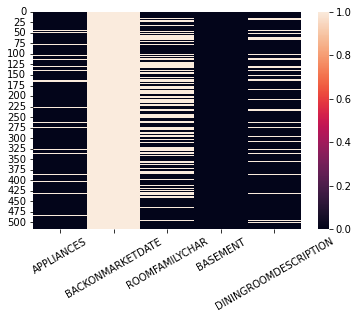

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
# Sample the dataframe and convert to Pandas
sample_df = df.select(columns).sample(False, 0.1, 42)
pandas_df = sample_df.toPandas()

# Convert all values to T/F
tf_df = pandas_df.isnull()

# Plot it
sns.heatmap(data=tf_df)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

# Set the answer to the column with the most missing data
answer = 'BACKONMARKETDATE'

# Imputing Missing Data

Missing data happens. If we make the assumption that our data is missing completely at random, we are making the assumption that what data we do have, is a good representation of the population. If we have a few values we could remove them or we could use the mean or median as a replacement.

In [14]:
# Count missing rows
missing = df.where(df['PDOM'].isNull()).count()

# Calculate the mean value
col_mean = df.agg({'PDOM': 'mean'}).collect()[0][0]

# Replacing with the mean value for that column
df.fillna(col_mean, subset=['PDOM'])

DataFrame[No.: string, MLSID: string, streetaddress: string, STREETNAME: string, PostalCode: string, StateOrProvince: string, City: string, SalesClosePrice: string, LISTDATE: string, LISTPRICE: string, LISTTYPE: string, OriginalListPrice: string, PricePerTSFT: string, FOUNDATIONSIZE: int, FENCE: string, MapLetter: string, SchoolDistrictNumber: string, DAYSONMARKET: int, offmarketdate: string, FIREPLACES: int, RoomArea4: string, roomtype: string, ROOF: string, RoomFloor4: string, PotentialShortSale: string, PoolDescription: string, PDOM: int, GarageDescription: string, SQFTABOVEGROUND: string, Taxes: string, RoomFloor1: string, RoomArea1: string, TAXWITHASSESSMENTS: string, TAXYEAR: string, LivingArea: string, UNITNUMBER: string, YEARBUILT: int, ZONING: string, STYLE: string, ACRES: string, CoolingDescription: string, APPLIANCES: string, backonmarketdate: string, ROOMFAMILYCHAR: string, RoomArea3: string, EXTERIOR: string, RoomFloor3: string, RoomFloor2: string, RoomArea2: string, Dinin

# Calculate Missing Percents

Automation is the future of data science. Learning to automate some of your data preparation pays dividends. In this exercise, we will automate dropping columns if they are missing data beyond a specific threshold.

In [20]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col
df = df.withColumnRenamed('No.','NO')
df = df.withColumn('NO', col('NO').cast(IntegerType()))
df.show(2)

+---+-----+--------------------+----------+----------+---------------+----------------+---------------+--------------+---------+---------------+-----------------+------------+--------------+-----+---------+--------------------+------------+---------------+----------+---------+--------------------+--------------------+----------+------------------+---------------+----+--------------------+---------------+-----+----------+---------+------------------+-------+----------+----------+---------+------------------+--------------------+-----+------------------+--------------------+----------------+--------------+---------+--------+----------+----------+---------+---------------------+--------------------+---------+---------+-----------+-----------------+-----+----------+--------------------+---------+----------+---------+----------+---------+----------+---------+----------+--------+---------------+-----------------+--------------+-----------------+-----------------+-------------------+---------

In [21]:
def column_dropper(df, threshold):
  # Takes a dataframe and threshold for missing values. Returns a dataframe.
  total_records = df.count()
  for col in df.columns:
    # Calculate the percentage of missing values
    missing = df.where(df[col].isNull()).count()
    missing_percent = missing / total_records
    # Drop column if percent of missing is more than threshold
    if missing_percent > threshold:
      df = df.drop(col)
  return df

# Drop columns that are more than 60% missing
df = column_dropper(df, 0.6)

# A Dangerous Join

In this exercise, we will be joining on Latitude and Longitude to bring in another dataset that measures how walk-friendly a neighborhood is. We'll need to be careful to make sure our joining columns are the same data type and ensure we are joining on the same precision (number of digits after the decimal) or our join won't work!

In [16]:
# walk_df = df
# # Cast data types
# walk_df = walk_df.withColumn('longitude', walk_df.longitude.cast('double'))
# walk_df = walk_df.withColumn('latitude', walk_df.latitude.cast('double'))

# # Round precision
# df = df.withColumn('longitude', round(df.longitude, 5))
# df = df.withColumn('latitude', round(df.latitude, 5))

# # Create join condition
# condition = [walk_df['latitude'] == df['latitude'], walk_df['longitude'] == df['longitude']]

# # Join the dataframes together
# join_df = df.join(walk_df, on=condition, how='inner')
# # Count non-null records from new field
# print(join_df.where(~join_df['walkscore'].isNull()).count())

# Spark SQL Join


Sometimes it is much easier to write complex joins in SQL. In this exercise, we will start with the join keys already in the same format and precision but will use SparkSQL to do the joining.

In [17]:
# # Register dataframes as tables
# df.createOrReplaceTempView('df')
# walk_df.createOrReplaceTempView('walk_df')

# # SQL to join dataframes
# join_sql = 	"""
# 			SELECT 
# 				*
# 			FROM df
# 			LEFT JOIN walk_df
# 			ON df.longitude = walk_df.longitude
# 			AND df.latitude = walk_df.latitude
# 			"""
# # Perform sql join
# joined_df = spark.sql(join_sql)

# Checking for Bad Joins

Joins can go bad silently if we are not careful, meaning they will not error out but instead return mangled data with more or less data than you'd intended. Let's take a look at a couple ways that joining incorrectly can change your data set for the worse.

In this example we will look at what happens if you join two dataframes together when the join keys are not the same precision and compare the record counts between the correct join and the incorrect one.

In [18]:
# # Join on mismatched keys precision 
# wrong_prec_cond = [df_orig['longitude'] == walk_df['longitude'], df_orig['latitude'] == walk_df['latitude']]
# wrong_prec_df = df_orig.join(walk_df, on=wrong_prec_cond, how='left')

# # Compare bad join to the correct one
# print(wrong_prec_df.where(wrong_prec_df['walkscore'].isNull()).count())
# print(correct_join_df.where(correct_join_df['walkscore'].isNull()).count())

# # Create a join on too few keys
# few_keys_cond = [df['longitude'] == walk_df['longitude']]
# few_keys_df = df.join(walk_df, on=few_keys_cond, how='left')

# # Compare bad join to the correct one
# print("Record Count of the Too Few Keys Join Example: " + str(few_keys_df.count()))
# print("Record Count of the Correct Join Example: " + str(correct_join_df.count()))